In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy
from scipy import stats
import torch
import matplotlib.pyplot as plt

import torch
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms

from torch.distributions import Gamma, Normal, Bernoulli, MultivariateNormal, \
    TransformedDistribution
from torch.distributions.transforms import PowerTransform

from tqdm.auto import trange

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Uniform
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [349]:
# Download MNIST dataset and create dataloaders. 
def binarize(imgs, integer=False):
    threshold = 127 if integer else 0.5
    imgs = imgs.clone()
    imgs[imgs < threshold] = 0.
    imgs[imgs >= threshold] = 1.
    return imgs

train_dataset = datasets.MNIST(root=".", train=True, download=True,
                         transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='.', train=False, download=True,
                             transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of points in dataset: {0}".format(train_dataset.data.shape[0]))
print("Number of batches per epoch: {0}".format(len(train_loader)))

Number of points in dataset: 60000
Number of batches per epoch: 938


In [350]:
# Download MNIST training data and convert to float32
# Only use a subset of the images
N = 10000
X3d_true = MNIST(root='.', train=True, transform=None, download=True).data
X3d_true = X3d_true.type(torch.float32)
X3d_true = X3d_true[:N]
_, H, W = X3d_true.shape

In [351]:
# s is the latent dimension
def FactorAnalysis(Y, s=2, num_iter=100):
    N = Y.shape[0]
    d = Y.shape[1]
    # center the data matrix
    X_bar = torch.mean(Y, axis=0)
    X = Y - X_bar 
    
    # randomly initialize Lambda and Phi
    Lambda = torch.randn([d,s])
    Phi = torch.diag(torch.abs(Normal(0,1).sample([d])))

    for _ in range(num_iter):
        G = torch.linalg.inv(torch.eye(s) + Lambda.T @ torch.linalg.inv(Phi) @ Lambda) # (s, s)
        E_z = torch.einsum('sd,Nd->Ns', G @ Lambda.T @ torch.linalg.inv(Phi), X) # (N, s)
        E_z_zT = N * G + torch.einsum('Ns,Nr->sr', E_z, E_z) #(s, s)
        Lambda = torch.linalg.solve(E_z_zT, X.T @ E_z, left=False) # XA = B (d, s)
        Phi = torch.diag(torch.diag(X.T @ X - Lambda @ E_z.T @ X) / N + 1e-4) #(d, d)
    return Lambda, Phi

In [352]:
X_true = X3d_true.reshape((N, -1))

In [353]:
s=4
a,b= FactorAnalysis(X_true,s=s)

In [354]:
num_samples = 64
z = torch.randn(num_samples, s)
k = torch.einsum('ds,ns->nd', a, z) + torch.mean(X_true, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


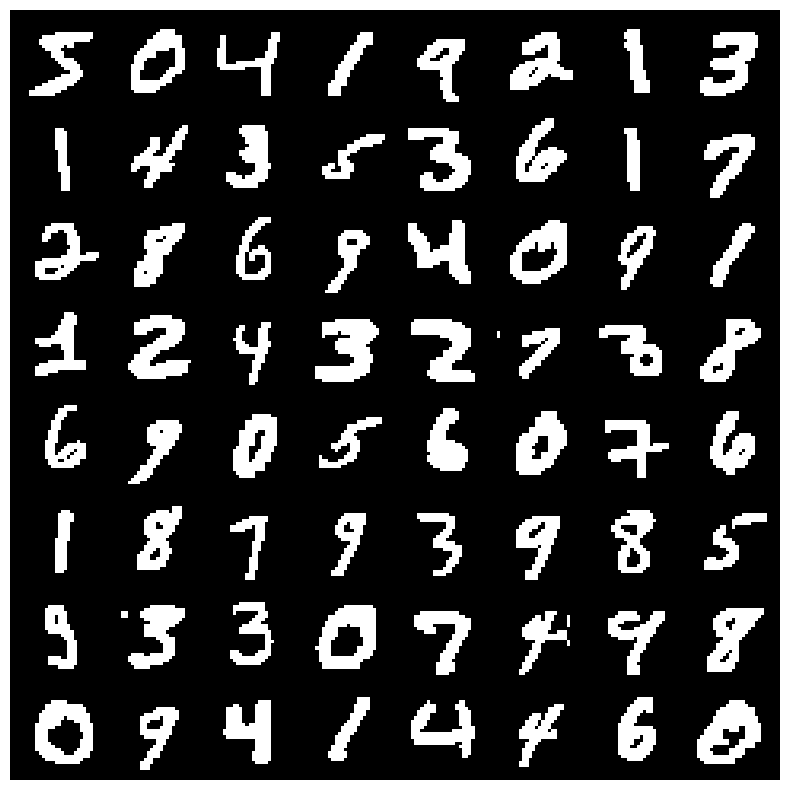

In [355]:
expected_xs = X_true[:64].reshape(-1, 28, 28).unsqueeze(1)

# Plot the expected_xs as a grid of images
expected_xs_grid = make_grid(expected_xs, nrow=8)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(expected_xs_grid.permute(1, 2, 0), vmin=0., vmax=1.)
plt.show()

In [364]:
def binarize(imgs, integer=False):
    threshold = 90
    imgs = imgs.clone()
    imgs[imgs < threshold] = 0.
    imgs[imgs >= threshold] = 1.
    return imgs

Text(0.5, 0.98, 'factor analysis generated images')

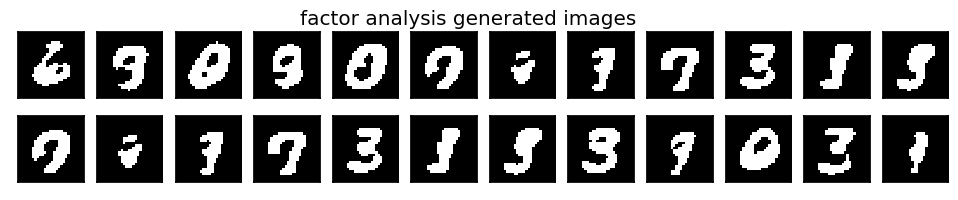

In [366]:
fig, axs = plt.subplots(2, 12, figsize=(12, 2))
for i in range(2):
    for j in range(12):
        axs[i, j].imshow(binarize(k.reshape(-1,28,28)[i * 5 + j]), interpolation="none", cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("factor analysis generated images")

In [127]:
# Interpolate between 8 randomly chosen start and end points
latent_starts = torch.randn(8, s)
latent_ends = torch.randn(8, s)

means = []
for t in torch.linspace(0, 1, 10):
    z = latent_starts + t * (latent_ends - latent_starts)

    k = torch.einsum('ds,ns->nd', a, z) + torch.mean(X_true, axis=0)
    means.append(k.reshape(-1, 28, 28).unsqueeze(0))

means_tensor = torch.vstack(means).permute(1, 0, 2, 3).reshape(-1, 28, 28).unsqueeze(1)


Text(0.5, 0.98, 'factor analysis interpolated images')

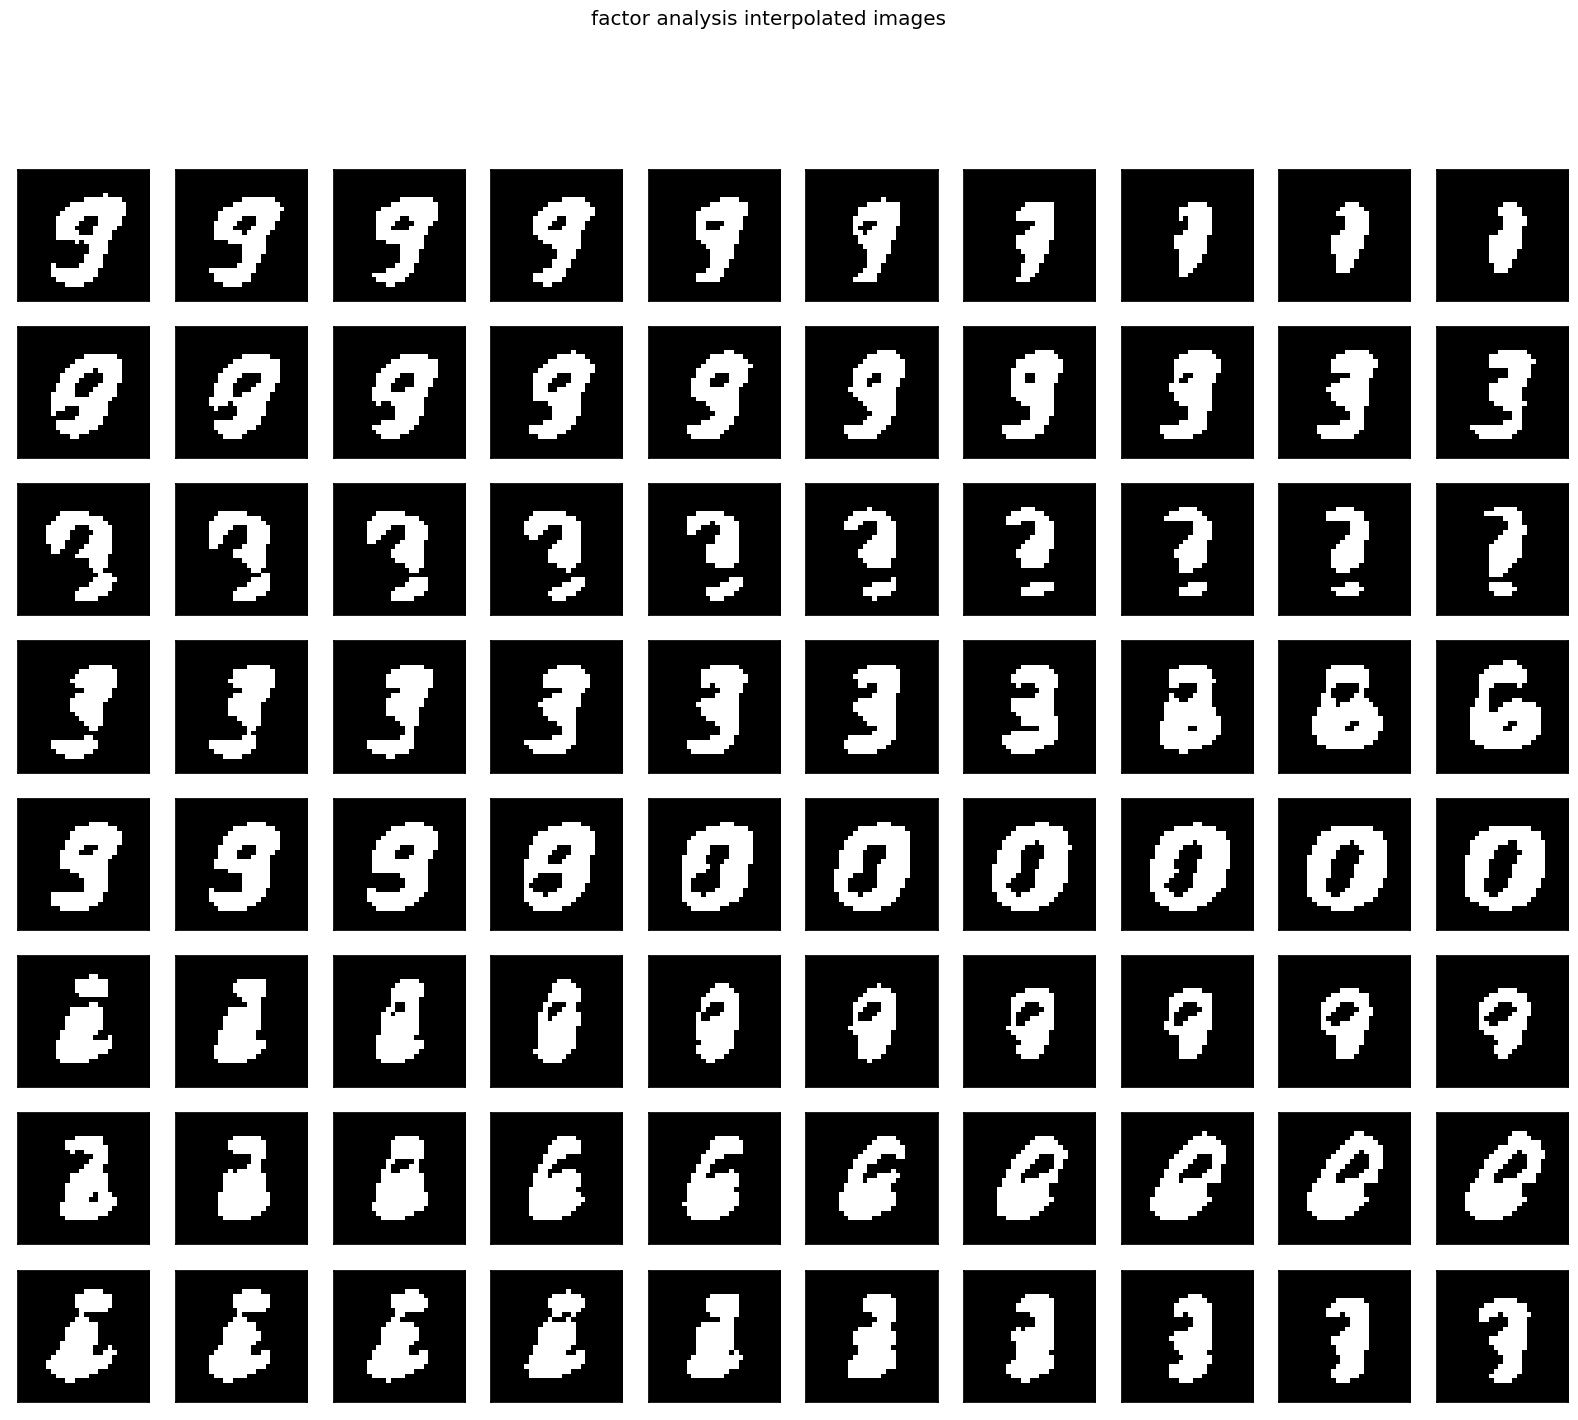

In [320]:
sample_grid = make_grid(means_tensor, nrow=10)
fig, axs = plt.subplots(8, 10, figsize=(20, 16))
for i in range(8):
    for j in range(10):
        axs[i, j].imshow(binarize(means_tensor.reshape(-1,28,28)[i * 10 + j]), interpolation="none", cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("factor analysis interpolated images")

In [238]:
def pca(X):
    """
    Compute the principal components and the fraction of variance explained 
    using the SVD of the scaled and centered data matrix. 

    Args:
        X: a shape (N, D) tensor

    Returns:
        pcs: a shape (D, D) tensor whose columns are the full set of D principal
            components. This matrix should be orthogonal.

        var_explained: a shape (D,) tensor whose entries are the variance 
            explained by each corresponding principal component.
    """
    ## 
    # Your code below.
    N = X.shape[0]
    X_bar = torch.mean(X, axis=0)
    Y = (X - X_bar) / np.sqrt(N)
    V, singular_values, UT = torch.linalg.svd(Y)
    eigenvalues = singular_values ** 2
    pcs = UT.T
    var_explained = eigenvalues / sum(eigenvalues)
    ##
    return pcs, var_explained, eigenvalues

In [239]:
pcs, uafar, eigsg = pca(X_true)

In [243]:
torch.sqrt(eigsg[:4])

tensor([591.5084, 497.4985, 457.8336, 431.0073])

In [169]:
pcs.shape

torch.Size([784, 784])

In [214]:
u,sig,vt = torch.linalg.svd(a)

In [242]:
sig

tensor([543.9537, 465.3731, 425.6534, 401.6326])

In [244]:
torch.sqrt(torch.sum((torch.log(torch.sqrt(eigsg[:4])) - torch.log(sig)) ** 2))

tensor(0.1476)

In [307]:
torch.sqrt(torch.sum((torch.log(torch.sqrt(eigsg[:4])) - torch.log(sig2[:4])) ** 2))

tensor(7.3608)

In [289]:
X_permuted=X_true
for i in range(10000):
    X_permuted[i] = X_true[i][torch.randperm(X_true.size()[1])]
X_permuted

tensor([[  3.,   0.,   0.,  ..., 166.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,  15.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 252.]])

In [290]:
araer, _ = FactorAnalysis(X_permuted,s=s)
_,sig2,_ = torch.linalg.svd(araer)
sig2

tensor([302.8154,  75.6619,  63.5636,  63.3529])

In [311]:
torch.linalg.norm(pcs[:,:4] @ pcs[:,:4].T - a @ a.T @ torch.linalg.inv(a @ a.T + b))

tensor(7.2389)

In [314]:
torch.linalg.norm(a @ a.T @ torch.linalg.inv(a @ a.T + b))

tensor(7.4057)

In [304]:
t=Normal(torch.mean(X_true,axis=0),torch.var(X_true,axis=0)**0.5).sample([10000])
t.shape

torch.Size([10000, 784])

In [305]:
_,sig2,_ = torch.linalg.svd(t)
sig2[:4]

tensor([94048.0391, 10079.5605, 10047.0020, 10016.3311])

In [185]:
def dist(x, y):
    _,sig1,_ = torch.linalg.svd(x)
    _,sig2,_ = torch.linalg.svd(y)
    return torch.sqrt(torch.sum((torch.log(sig1) - torch.log(sig2)) ** 2))

In [228]:
dist(u[:,:4],pcs[:,:4])

tensor(7.3967e-07)

In [230]:
dist(pcs[:,:4],torch.randn(784,4))

tensor(6.7207)